In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pickle as pkl
import skimage
import yaml
from typing import Union, Optional, Type, Tuple, List, Dict
import sys
from skimage.color import label2rgb
import json
# import nrrd

import pandas as pd
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from statsmodels.stats.multitest import multipletests


# Project Root
# used for searching packages and functions
# TODO: enter your project root dir here
ROOT_DIR = '/project/Xie_Lab/zgu/xiao_multiplex/multiTAP/image_cytof'

sys.path.append(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'image_cytof'))
from cytof.hyperion_preprocess import cytof_read_data_roi
from cytof.utils import save_multi_channel_img, check_feature_distribution
from cytof.classes import CytofImageTiff
from cytof.classes import CytofCohort

/project/Xie_Lab/zgu/conda_stuff/envs/cytof-shared/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def flatten_coexpression_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Flattens a symmetric co-expression matrix (including the diagonal)
    into a single-row wide-format DataFrame.
    
    Parameters:
        df (pd.DataFrame): A square symmetric DataFrame of co-expression values.
        
    Returns:
        pd.DataFrame: A single-row wide-format DataFrame where each column is a
                      unique pair (e.g., 'GeneA_GeneB') and the value is the
                      corresponding co-expression score.
    """
    if df.shape[0] != df.shape[1]:
        raise ValueError("Input DataFrame must be square.")
    if not df.columns.equals(df.index):
        raise ValueError("DataFrame must have matching row and column labels.")

    # Get upper triangle indices (including diagonal)
    mask = np.triu(np.ones(df.shape), k=0).astype(bool)
    i, j = np.where(mask)

    # Build column names and extract values
    colnames = [f"{df.index[r]}_{df.columns[c]}" for r, c in zip(i, j)]
    values = df.values[i, j]

    # Return as single-row wide-format DataFrame
    return pd.DataFrame([values], columns=colnames)


# read from saved csv
these csv contains flattened values of co-expression, i.e. long format

In [3]:
# concatenate all files 
SAVED_GROUPS = [86, 87, 88, 175, 176, 178]
BASE_CSV_DIR = "/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work"

# combine individual save groups as one
df_list = []
for prefix in SAVED_GROUPS:
    csv_path = os.path.join(BASE_CSV_DIR, f"nsclc_save_group{prefix}", f"nsclc_save_group{prefix}_flattened_coexp.csv")
    df = pd.read_csv(csv_path)

    df_list.append(df)

combined_co_exp_df = pd.concat(df_list, axis=0, ignore_index=True)

print("number of unique patients:", combined_co_exp_df['Patient_ID'].nunique())
combined_co_exp_df

number of unique patients: 1067


,Myelope_276((2996))Y89-Y89_cell_sum_Myelope_276((2996))Y89-Y89_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_FSP1 S1_2263((3411))In113-In113_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_SMA_174((3277))In115-In115_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_117Sn-Sn117_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Histone_126((2797))Pr141-Pr141_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_fap_323((3412))Nd142-Nd142_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_HLA-DR_1849((3362))Nd143-Nd143_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_CD146_22((3259))Nd144-Nd144_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Cadheri_2088((2893))Nd145-Nd145_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Carboni_2443((2757))Nd146-Nd146_cell_sum,...,Ki-67_142((3418))Pt194-Pt194_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_206Pb-Pb206_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_206Pb-Pb206_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,206Pb-Pb206_cell_sum_206Pb-Pb206_cell_sum,206Pb-Pb206_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,CD15_627((2997))Bi209-Bi209_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,Patient_ID
0,1.979045,1.115034,0.000000,0.000000,0.871179,0.578629,1.341648,1.267909,1.454229,0.703568,...,0.883946,1.102446,0.712793,1.128881,0.959777,0.425192,1.823039,0.660714,0.788275,86_1
1,2.382156,0.000000,0.796218,0.294103,0.828642,0.902994,0.527613,0.000000,0.000000,0.000000,...,0.969848,1.056054,0.911259,1.160644,1.158585,0.917235,2.486655,1.678982,1.863530,86_10
2,2.047943,1.267223,0.000000,1.806474,1.802560,1.965120,1.539448,0.000000,0.000000,0.000000,...,0.000000,1.674885,1.859238,0.000000,0.000000,0.000000,1.773173,1.588979,2.518626,86_100
3,1.410234,0.799072,-1.044452,0.077779,-0.153864,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.948933,1.199368,-0.062187,1.194529,1.191349,-0.042236,2.594154,0.242502,1.090121,86_101
4,2.248015,0.000000,0.599337,0.166105,0.106557,-0.199440,0.473802,0.421676,0.263562,0.000000,...,0.982256,0.740337,0.350247,1.242208,0.604612,0.253514,2.071617,0.138838,0.813769,86_102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,2.285995,0.000000,0.499456,0.000000,-0.084696,0.347591,0.393954,0.444161,0.000000,0.000000,...,0.984859,0.949643,0.441578,1.545697,1.322241,0.815356,2.139781,1.357929,1.514361,178_566
1063,1.477665,0.773665,-1.118672,0.112171,0.413726,0.819803,0.469102,0.637127,0.273676,0.858789,...,0.987382,0.962810,0.555469,1.056350,1.030436,0.565107,2.343000,0.570546,0.595760,178_567
1064,1.531467,1.227682,0.490379,0.707408,0.445396,0.885285,0.783315,0.743295,0.133507,0.862496,...,0.375263,0.571577,0.600495,0.721622,-0.593667,0.471693,1.154463,0.690623,1.441461,178_569
1065,1.738806,0.000000,0.067572,0.000000,0.000000,0.000000,-0.019734,1.132838,0.000000,0.000000,...,0.644188,1.143122,0.466084,1.063364,0.886350,0.376977,2.274743,0.633509,1.111654,178_570


In [4]:
# add the clinical data
pt_clinical_data = pd.read_csv('/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/clinical_data_ROI.csv')
pt_clinical_data = pt_clinical_data[['Patient_ID', 'OS', 'DFS', 'Ev.O']]

# remove duplicates
pt_clinical_data = pt_clinical_data.drop_duplicates(keep='first')
pt_clinical_data


,Patient_ID,OS,DFS,Ev.O
0,175_1,254.0,NaN,1.0
1,175_5,3420.0,3420.0,1.0
2,175_9,1312.0,1312.0,1.0
3,175_13,1950.0,1950.0,1.0
4,175_21,820.0,820.0,1.0
...,...,...,...,...
2054,88_521,596.0,370.0,1.0
2055,88_525,323.0,323.0,1.0
2056,88_529,1707.0,1707.0,0.0
2057,88_533,1652.0,1652.0,0.0


In [5]:
# merge coexp and clinical data
coexp_clinical_merged = combined_co_exp_df.merge(pt_clinical_data, how='left', on='Patient_ID')

# exclude pt where OS, outcome is unavailable
coexp_clinical_merged = coexp_clinical_merged[~coexp_clinical_merged['OS'].isna()].reset_index(drop=True)
coexp_clinical_merged = coexp_clinical_merged[~coexp_clinical_merged['Ev.O'].isna()].reset_index(drop=True)
print("number of unique patients:", coexp_clinical_merged['Patient_ID'].nunique())

coexp_clinical_merged

number of unique patients: 1064


,Myelope_276((2996))Y89-Y89_cell_sum_Myelope_276((2996))Y89-Y89_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_FSP1 S1_2263((3411))In113-In113_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_SMA_174((3277))In115-In115_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_117Sn-Sn117_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Histone_126((2797))Pr141-Pr141_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_fap_323((3412))Nd142-Nd142_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_HLA-DR_1849((3362))Nd143-Nd143_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_CD146_22((3259))Nd144-Nd144_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Cadheri_2088((2893))Nd145-Nd145_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Carboni_2443((2757))Nd146-Nd146_cell_sum,...,Caveoli_1945((2899))Pt195-Pt195_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_206Pb-Pb206_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,206Pb-Pb206_cell_sum_206Pb-Pb206_cell_sum,206Pb-Pb206_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,CD15_627((2997))Bi209-Bi209_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,Patient_ID,OS,DFS,Ev.O
0,1.979045,1.115034,0.000000,0.000000,0.871179,0.578629,1.341648,1.267909,1.454229,0.703568,...,1.128881,0.959777,0.425192,1.823039,0.660714,0.788275,86_1,2593.0,2593.0,1.0
1,2.382156,0.000000,0.796218,0.294103,0.828642,0.902994,0.527613,0.000000,0.000000,0.000000,...,1.160644,1.158585,0.917235,2.486655,1.678982,1.863530,86_10,36.0,36.0,1.0
2,2.047943,1.267223,0.000000,1.806474,1.802560,1.965120,1.539448,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.773173,1.588979,2.518626,86_100,489.0,429.0,1.0
3,1.410234,0.799072,-1.044452,0.077779,-0.153864,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.194529,1.191349,-0.042236,2.594154,0.242502,1.090121,86_101,4465.0,4465.0,0.0
4,2.248015,0.000000,0.599337,0.166105,0.106557,-0.199440,0.473802,0.421676,0.263562,0.000000,...,1.242208,0.604612,0.253514,2.071617,0.138838,0.813769,86_102,875.0,795.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2.285995,0.000000,0.499456,0.000000,-0.084696,0.347591,0.393954,0.444161,0.000000,0.000000,...,1.545697,1.322241,0.815356,2.139781,1.357929,1.514361,178_566,2076.0,1437.0,0.0
1060,1.477665,0.773665,-1.118672,0.112171,0.413726,0.819803,0.469102,0.637127,0.273676,0.858789,...,1.056350,1.030436,0.565107,2.343000,0.570546,0.595760,178_567,82.0,82.0,1.0
1061,1.531467,1.227682,0.490379,0.707408,0.445396,0.885285,0.783315,0.743295,0.133507,0.862496,...,0.721622,-0.593667,0.471693,1.154463,0.690623,1.441461,178_569,1860.0,1860.0,0.0
1062,1.738806,0.000000,0.067572,0.000000,0.000000,0.000000,-0.019734,1.132838,0.000000,0.000000,...,1.063364,0.886350,0.376977,2.274743,0.633509,1.111654,178_570,1399.0,114.0,1.0


# running survival analysis

In [6]:
# remove survival column
co_exp_cols = np.array(coexp_clinical_merged.columns)
co_exp_cols = np.delete(co_exp_cols, [-1,-2,-3,-4])
print('# of features to compute:', len(co_exp_cols))
# test case
# co_exp_cols = co_exp_cols[:5]

# of features to compute: 946


In [7]:
p_val_list = []
for col in co_exp_cols:

    cph = CoxPHFitter()

    # subset that column
    subset_data = coexp_clinical_merged[['OS', 'Ev.O', col]]

    # fit a univariate model
    cph.fit(subset_data, duration_col='OS', event_col='Ev.O')
    p_val = cph.summary['p'].values

    p_val_list.append(p_val)

In [9]:
# Make sure pvalues is a flat array/list
pvalues = np.array(p_val_list).flatten()

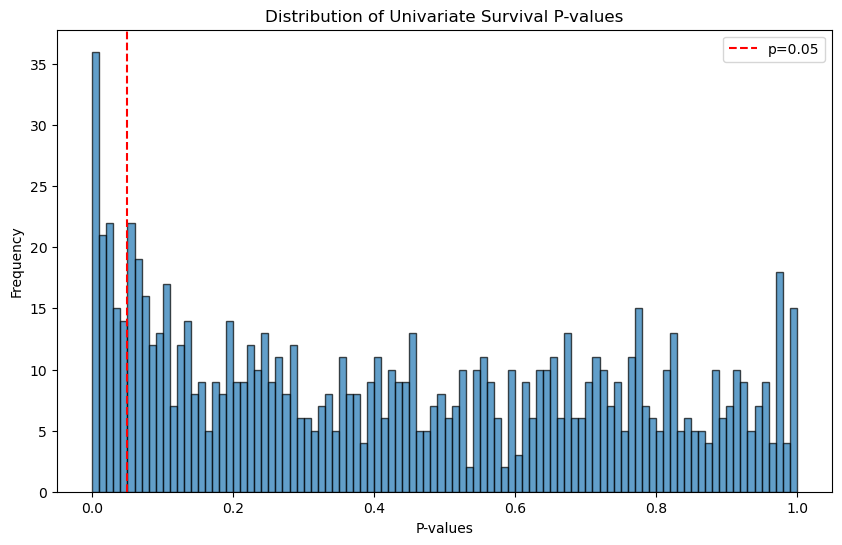

In [10]:
%matplotlib inline
# Simple histogram
plt.figure(figsize=(10, 6))
plt.hist(pvalues, bins=100, alpha=0.7, edgecolor='black')
plt.xlabel('P-values')
plt.ylabel('Frequency')
plt.title('Distribution of Univariate Survival P-values')
plt.axvline(x=0.05, color='red', linestyle='--', label='p=0.05')
plt.legend()
plt.show()

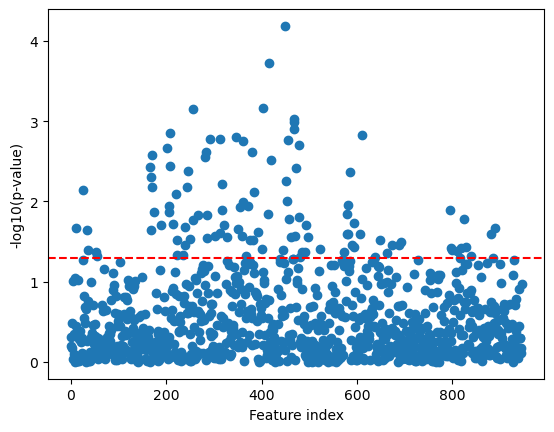

In [11]:
plt.scatter(range(len(p_val_list)), -np.log10(p_val_list))
plt.xlabel('Feature index')
plt.ylabel('-log10(p-value)')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
plt.show()

In [12]:
# error corrections
# Benjamini-Hochberg FDR correction
rejected_fdr, pvals_fdr, alpha_sidak, alpha_bonf = multipletests(pvalues, method='fdr_bh')

print(f"Significant after FDR: {sum(rejected_fdr)}/{len(pvalues)}")

Significant after FDR: 0/946


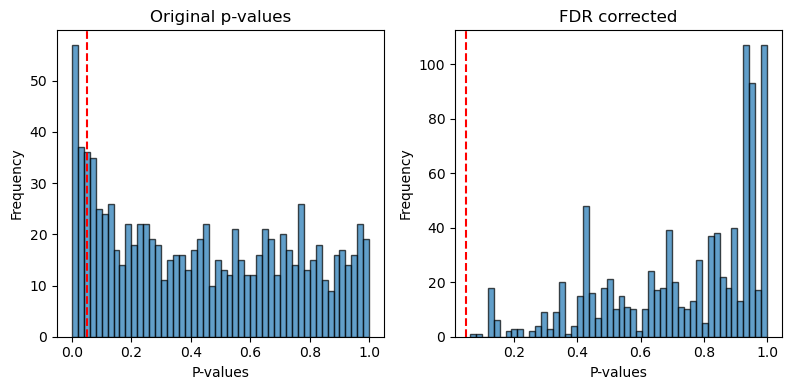

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1,3,1)
plt.hist(pvalues, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(0.05, color='red', linestyle='--', )
plt.title('Original p-values')
plt.xlabel('P-values')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.hist(pvals_fdr, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(0.05, color='red', linestyle='--')
plt.title('FDR corrected')
plt.xlabel('P-values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

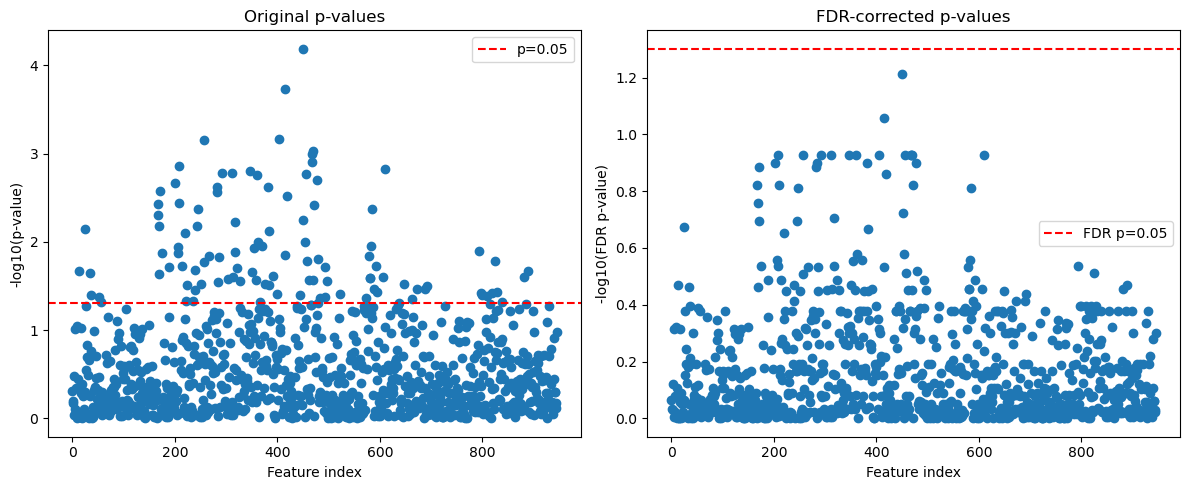

In [19]:
plt.figure(figsize=(12, 5))

# Original p-values
plt.subplot(1, 2, 1)
plt.scatter(range(len(p_val_list)), -np.log10(p_val_list))
plt.xlabel('Feature index')
plt.ylabel('-log10(p-value)')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
plt.title('Original p-values')
plt.legend()

# FDR-corrected p-values
plt.subplot(1, 2, 2)
plt.scatter(range(len(pvals_fdr)), -np.log10(pvals_fdr))
plt.xlabel('Feature index')
plt.ylabel('-log10(FDR p-value)')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='FDR p=0.05')
plt.title('FDR-corrected p-values')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
cph = CoxPHFitter()

subset_data = coexp_clinical_merged[['OS', 'Ev.O', 'Myelope_276((2996))Y89-Y89_cell_sum_Myelope_276((2996))Y89-Y89_cell_sum']]

cph.fit(subset_data, duration_col='OS', event_col='Ev.O')
p_val = cph.summary['p'].values

# cph.print_summary()  # access the individual results using cph.summary
# cph_pretty = cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]
# cph_pretty['prints'] = cph_pretty.apply(lambda row: f"{row['exp(coef)']:.2f} ({row['exp(coef) lower 95%']:.2f} - {row['exp(coef) upper 95%']:.2f})", axis=1)
# cph_pretty

In [16]:
p_val

array([0.49520504])

88_363     3
175_111    2
175_165    2
175_169    2
175_173    2
          ..
178_387    1
178_383    1
178_379    1
178_423    1
87_250     1
Name: Patient_ID, Length: 1070, dtype: int64

In [54]:

# Convert Patient_ID column to categorical with this order to sort accordingly
pt_subset['Patient_ID'] = pd.Categorical(pt_subset['Patient_ID'], categories=patient_order, ordered=True)

# Sort the dataframe by Patient_ID categorical order
sorted_df = pt_subset.sort_values('Patient_ID')
small_sorted = sorted_df.head(10)
small_sorted

,RoiID,Patient_ID,OS,DFS,Ev.O
1851,"88_A4,2",88_363,2659.0,2659.0,0.0
1779,"88_A4,2",88_363,2659.0,2659.0,0.0
1765,"88_A3,2",88_363,2659.0,2659.0,0.0
0,"175_A1,1",175_1,254.0,NaN,1.0
16,"175_A2,1",175_1,254.0,NaN,1.0
1363,"87_A1,11",87_202,1068.0,367.0,1.0
1380,"87_A2,11",87_202,1068.0,367.0,1.0
1350,"86_C8,4",86_128,332.0,332.0,0.0
1344,"86_C7,4",86_128,332.0,332.0,0.0
1346,"86_C7,7",86_140,3531.0,3531.0,1.0


In [10]:
# among the pt that have multiple TMA, check OS, DFS, Ev.O are consistent within each pt
columns_to_check = ['OS', 'Ev.O', 'Relapse', 'DFS', 'Smok', 'Relapse']  

# for each pt check # of unique elements in those columns
consistency_df = sorted_df.groupby('Patient_ID')[columns_to_check].nunique()

# each column should only have one
consistency_df['all_consistent'] = (consistency_df <= 1).all(axis=1)

# # get those not consistent
inconsistent_pt = consistency_df[~consistency_df['all_consistent']].reset_index()['Patient_ID']
inconsistent_pt

Series([], Name: Patient_ID, dtype: category
Categories (1070, object): ['88_363' < '175_1' < '87_202' < '86_128' ... '86_133' < '86_145' < '86_149' < '87_250'])

In [11]:
sorted_df[sorted_df['Patient_ID'].isin(inconsistent_pt)]

,RoiID,OS,Ev.O,Relapse,DFS,Smok,Patient_ID


In [12]:
single_row_pt = pt_subset.groupby('Patient_ID').mean()
single_row_pt

/tmp/ipykernel_1165677/4152369970.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  single_row_pt = pt_subset.groupby('Patient_ID').mean()


,OS,Ev.O,Relapse,DFS,Smok
Patient_ID,,,,,
88_363,2659.0,0.0,0.0,2659.0,1.0
175_1,254.0,1.0,NaN,NaN,3.0
87_202,1068.0,1.0,1.0,367.0,1.0
86_128,332.0,0.0,1.0,332.0,1.0
86_140,3531.0,1.0,0.0,3531.0,3.0
...,...,...,...,...,...
86_113,603.0,0.0,0.0,603.0,1.0
86_133,2046.0,0.0,0.0,2046.0,1.0
86_145,710.0,1.0,1.0,554.0,1.0


In [13]:
print(np.unique(single_row_pt['Ev.O'], return_counts=True))
print(np.unique(single_row_pt['Smok'], return_counts=True))
print(np.unique(single_row_pt['Relapse'], return_counts=True))

# print(len(np.unique(pt_subset['Patient_ID'])))

(array([ 0.,  1., nan]), array([337, 730,   3]))
(array([ 0.,  1.,  2.,  3., nan]), array([ 86, 730,  26, 197,  31]))
(array([ 0.,  1., nan]), array([555, 480,  35]))


In [68]:
combined_df['OS_one_Year'] = pt_subset['OS_one_Year'].values
combined_df

,Myelope_276((2996))Y89-Y89_cell_sum_Myelope_276((2996))Y89-Y89_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_FSP1 S1_2263((3411))In113-In113_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_SMA_174((3277))In115-In115_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_117Sn-Sn117_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Histone_126((2797))Pr141-Pr141_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_fap_323((3412))Nd142-Nd142_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_HLA-DR_1849((3362))Nd143-Nd143_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_CD146_22((3259))Nd144-Nd144_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Cadheri_2088((2893))Nd145-Nd145_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Carboni_2443((2757))Nd146-Nd146_cell_sum,...,Ki-67_142((3418))Pt194-Pt194_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_206Pb-Pb206_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_206Pb-Pb206_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,206Pb-Pb206_cell_sum_206Pb-Pb206_cell_sum,206Pb-Pb206_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,CD15_627((2997))Bi209-Bi209_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,OS_one_Year
0,2.389949,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.365713,0.968170,0.656991,2.110415,0.935796,0.531200,2.016158,0.832462,1.310333,True
1,2.525314,0.0,0.000000,0.049678,0.000000,0.000000,0.941484,0.956723,0.0,1.053351,...,0.955255,1.088464,0.611343,1.163134,1.034049,0.000000,2.665892,0.000000,2.665892,False
2,1.871431,0.0,-0.005308,0.019321,0.144955,0.851278,0.000000,0.000000,0.0,0.000000,...,0.999691,0.000000,0.695943,1.294854,0.000000,0.554505,0.000000,0.000000,1.258287,False


In [70]:
from sklearn.linear_model import LogisticRegression

# Select features (co-expression values) and binary outcome
X = combined_df.drop(columns=['OS_one_Year'])  # or 'survived_1yr'
y = combined_df['OS_one_Year']  # or 'survived_1yr'

# Fit logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X, y)



LogisticRegression(max_iter=1000)

In [71]:
# Get feature coefficients
coef = model.coef_[0]
feature_importance = pd.Series(coef, index=X.columns)

# Sort by absolute value to see strongest effects
feature_importance_abs = feature_importance.abs().sort_values(ascending=False)
print("Top features by absolute coefficient (unregularized):")
print(feature_importance_abs.head(10))

Top features by absolute coefficient (unregularized):
p75(CD2_1840((2193))Tb159-Tb159_cell_sum_p75(CD2_1840((2193))Tb159-Tb159_cell_sum    0.052324
117Sn-Sn117_cell_sum_117Sn-Sn117_cell_sum                                            0.049987
FSP1 S1_2263((3411))In113-In113_cell_sum_K-Cadhe_2600((3417))Yb176-Yb176_cell_sum    0.049932
Podopla_1463((2619))Eu153-Eu153_cell_sum_CD34_2254((3337))Er170-Er170_cell_sum       0.047473
FSP1 S1_2263((3411))In113-In113_cell_sum_Indolea_2281((3014))Eu151-Eu151_cell_sum    0.044211
Indolea_2281((3014))Eu151-Eu151_cell_sum_K-Cadhe_2600((3417))Yb176-Yb176_cell_sum    0.042148
Podopla_1463((2619))Eu153-Eu153_cell_sum_CD279(P_1743((3414))Gd155-Gd155_cell_sum    0.041359
Podopla_1463((2619))Eu153-Eu153_cell_sum_Vimenti_655((1939))Dy162-Dy162_cell_sum     0.040346
VCAM1_1986((3332))Nd148-Nd148_cell_sum_CD20_36((3369))Sm149-Sm149_cell_sum           0.039529
117Sn-Sn117_cell_sum_FOXP3_115((2911))Dy163-Dy163_cell_sum                           0.038305
dtype:

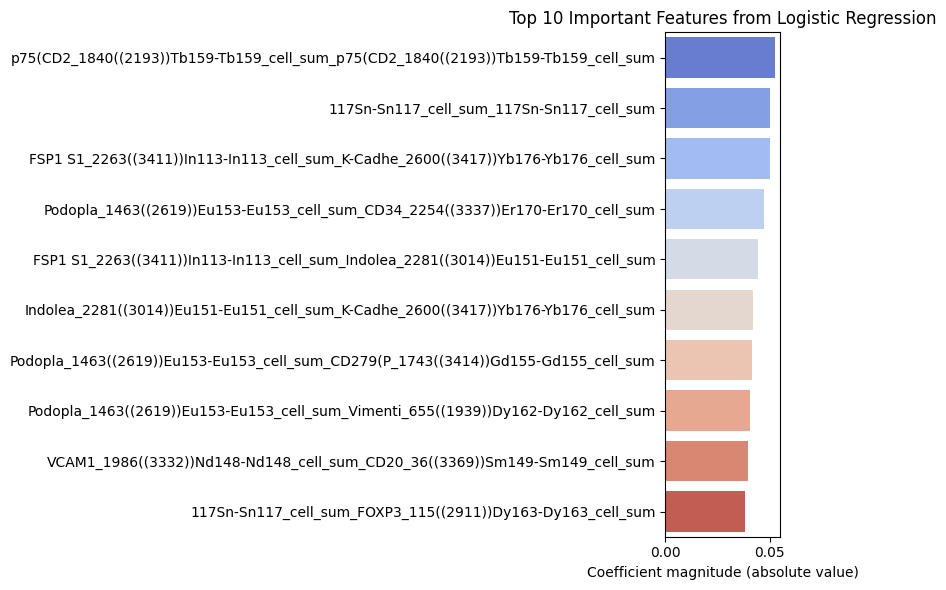

In [72]:
# Select top 10 features by absolute coefficient value
top_features = feature_importance_abs.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='coolwarm')

plt.xlabel('Coefficient magnitude (absolute value)')
plt.title('Top 10 Important Features from Logistic Regression')
plt.tight_layout()
plt.show()

# scratch

In [ ]:
"""

For each save group in sequential [0,1,2,3,4,5,175]
-	Load the corresponding pkl file 
-	subset pt_id_savegroup into that group, exclude pt_id that are already processed.
-	further subset to pt that are saved in ONE group only
-	for all patients in the refined subset, index the two TMAs, put them into ONE cohort, run cohort.coexpression, save as flattened df. Mark processed pt_id.
-	Now for the patients in TWO groups, load the next save group pkl, index from the two .pkl with ONE cytof_img each
-	Put the two into ONE cohort, then save as flattened df. Mark processed pt_id
-	Delete variable additional loaded pkl

"""

In [5]:
# contains the final list of patient included after quality check
# for exclusion criteria see redistribute_save_groups.ipynb
roi_pt_id_mapping = pd.read_csv('/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/roi_pt_id_mapping.csv')
# redistribute_group = [86, 87, 88, 176, 178] # 175 is excluded bc it was processed separately

prefix = 86
prefix_pt_roi_path = f'/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_save_group{prefix}/nsclc_save_group{prefix}.pkl'
cytof_cohort_whole_slide = pkl.load(open(prefix_pt_roi_path, 'rb'))
# roi_list = list(cytof_cohort_whole_slide.cytof_images.keys())
# roi_list = roi_list[:2]
pt_prefix_rois = roi_pt_id_mapping[roi_pt_id_mapping['ROI'].str.startswith(f'{prefix}_')].reset_index(drop=True)


In [21]:
pt_prefix_rois

,SLIDE,ROI,input file,save_group,roi_mappable,RoiID,Patient_ID,OS,DFS,Ev.O
0,NSCLC_ALL,86_A_A1_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,1","86_A1,1",86_1,2593.0,2593.0,1.0
1,NSCLC_ALL,86_A_A1_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,2","86_A1,2",86_5,158.0,158.0,1.0
2,NSCLC_ALL,86_A_A1_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,5","86_A1,5",86_17,121.0,NaN,1.0
3,NSCLC_ALL,86_A_A1_6,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,6","86_A1,6",86_21,521.0,521.0,1.0
4,NSCLC_ALL,86_A_A1_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,7","86_A1,7",86_25,2382.0,1250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
231,NSCLC_ALL,86_B_B8_9,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_B8,9","86_B8,9",86_92,138.0,NaN,1.0
232,NSCLC_ALL,86_B_B8_10,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_B8,10","86_B8,10",86_96,336.0,336.0,1.0
233,NSCLC_ALL,86_B_B8_11,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_B8,11","86_B8,11",86_100,489.0,429.0,1.0
234,NSCLC_ALL,86_B_B8_12,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_B8,12","86_B8,12",86_104,4451.0,4451.0,0.0


In [15]:
prefix_pt_ids = np.unique([pt_prefix_rois['Patient_ID']])

# process for each patient
for pt_id in prefix_pt_ids:
    per_pt_roi_dict = dict() # to be pass into CytofCohort later

    # load the pt's ROIs
    df_to_load = pt_prefix_rois[pt_prefix_rois['Patient_ID']==pt_id]

    # load all of this pt's ROI into a new dict
    for index, row in df_to_load.iterrows():
        new_key = f"{row['SLIDE']}_{row['ROI']}"
        per_pt_roi_dict[new_key] = cytof_cohort_whole_slide.cytof_images[new_key]

    # df_cohort not saved, creating one automatically from CytofCohort
    per_pt_cohort = CytofCohort(cytof_images=per_pt_roi_dict, dir_out=None)
    per_pt_cohort.batch_process_feature()
    per_pt_cohort.generate_summary()

    slide_co_expression_dict = per_pt_cohort.co_expression_analysis()

    edge_percentage_norm, column_names = slide_co_expression_dict['NSCLC_ALL']

    break

Getting thresholds for cell sum of all markers.


In [20]:
column_names

edge_perc_remapped = pd.DataFrame(edge_percentage_norm, index=column_names, columns=column_names)


flat_edge_perc_remapped = flatten_coexpression_matrix(edge_perc_remapped)
flat_edge_perc_remapped

,Myelope_276((2996))Y89-Y89_cell_sum_Myelope_276((2996))Y89-Y89_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_FSP1 S1_2263((3411))In113-In113_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_SMA_174((3277))In115-In115_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_117Sn-Sn117_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Histone_126((2797))Pr141-Pr141_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_fap_323((3412))Nd142-Nd142_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_HLA-DR_1849((3362))Nd143-Nd143_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_CD146_22((3259))Nd144-Nd144_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Cadheri_2088((2893))Nd145-Nd145_cell_sum,Myelope_276((2996))Y89-Y89_cell_sum_Carboni_2443((2757))Nd146-Nd146_cell_sum,...,Ki-67_142((3418))Pt194-Pt194_cell_sum_Ki-67_142((3418))Pt194-Pt194_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_206Pb-Pb206_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_Caveoli_1945((2899))Pt195-Pt195_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_206Pb-Pb206_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,206Pb-Pb206_cell_sum_206Pb-Pb206_cell_sum,206Pb-Pb206_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum,CD15_627((2997))Bi209-Bi209_cell_sum_CD15_627((2997))Bi209-Bi209_cell_sum
0,1.979045,1.115034,0.0,0.0,0.871179,0.578629,1.341648,1.267909,1.454229,0.703568,...,1.230213,0.883946,1.102446,0.712793,1.128881,0.959777,0.425192,1.823039,0.660714,0.788275


In [25]:
per_pt_roi_dict

{'NSCLC_ALL_86_A_A1_1': CytofImage(slide=NSCLC_ALL, roi=86_A_A1_1),
 'NSCLC_ALL_86_A_A2_1': CytofImage(slide=NSCLC_ALL, roi=86_A_A2_1)}

In [23]:
pt_id
edge_perc_remapped

,Myelope_276((2996))Y89-Y89_cell_sum,FSP1 S1_2263((3411))In113-In113_cell_sum,SMA_174((3277))In115-In115_cell_sum,117Sn-Sn117_cell_sum,Histone_126((2797))Pr141-Pr141_cell_sum,fap_323((3412))Nd142-Nd142_cell_sum,HLA-DR_1849((3362))Nd143-Nd143_cell_sum,CD146_22((3259))Nd144-Nd144_cell_sum,Cadheri_2088((2893))Nd145-Nd145_cell_sum,Carboni_2443((2757))Nd146-Nd146_cell_sum,...,CD4_2293((3000))Yb171-Yb171_cell_sum,CD31_1859((3370))Yb172-Yb172_cell_sum,anti-Hu_1950((2832))Yb173-Yb173_cell_sum,CCL21 6_2177((2889))Yb174-Yb174_cell_sum,panCyto_234((2745))Lu175-Lu175_cell_sum,K-Cadhe_2600((3417))Yb176-Yb176_cell_sum,Ki-67_142((3418))Pt194-Pt194_cell_sum,Caveoli_1945((2899))Pt195-Pt195_cell_sum,206Pb-Pb206_cell_sum,CD15_627((2997))Bi209-Bi209_cell_sum
Myelope_276((2996))Y89-Y89_cell_sum,1.979045,1.115034,0.000000,0.000000,0.871179,0.578629,1.341648,1.267909,1.454229,0.703568,...,1.227961,0.671574,0.651419,1.406879,-0.481414,1.345073,0.696027,0.515614,0.908379,0.766316
FSP1 S1_2263((3411))In113-In113_cell_sum,1.115034,2.631047,0.000000,0.000000,0.933755,0.865705,1.956866,1.663621,0.000000,0.689614,...,1.629463,0.957821,1.230763,1.300156,0.584564,1.767982,0.983163,0.757703,1.264858,0.418815
SMA_174((3277))In115-In115_cell_sum,0.000000,0.000000,1.590844,0.000000,0.000000,0.233278,0.000000,0.000000,1.092653,0.000000,...,0.000000,-0.673674,0.000000,0.000000,-0.270556,0.000000,-0.774268,0.571568,-0.180478,0.000000
117Sn-Sn117_cell_sum,0.000000,0.000000,0.000000,2.111267,0.307405,0.714027,0.000000,0.000000,0.000000,0.361845,...,1.358349,0.998794,0.000000,0.695161,0.000000,0.875215,0.866192,0.692463,1.122207,0.514940
Histone_126((2797))Pr141-Pr141_cell_sum,0.871179,0.933755,0.000000,0.307405,1.484832,0.604194,0.870285,1.179004,1.292040,0.604194,...,0.916233,0.635108,0.979270,0.767225,0.565232,1.096818,0.651003,0.734194,0.667741,0.425809
fap_323((3412))Nd142-Nd142_cell_sum,0.578629,0.865705,0.233278,0.714027,0.604194,1.237762,1.105612,1.013092,1.228131,0.561069,...,1.193815,0.950637,0.276348,0.967909,-0.226102,1.119648,0.929181,0.796229,1.057603,0.527221
HLA-DR_1849((3362))Nd143-Nd143_cell_sum,1.341648,1.956866,0.000000,0.000000,0.870285,1.105612,2.698925,1.851164,0.000000,0.628491,...,1.820965,1.196992,1.161981,1.518287,0.524112,1.673895,1.223123,0.998297,1.496237,0.785670
CD146_22((3259))Nd144-Nd144_cell_sum,1.267909,1.663621,0.000000,0.000000,1.179004,1.013092,1.851164,2.533067,2.238395,1.013092,...,1.798050,1.172453,0.779223,1.155631,0.129620,1.628402,0.926408,1.029751,1.290800,0.632339
Cadheri_2088((2893))Nd145-Nd145_cell_sum,1.454229,0.000000,1.092653,0.000000,1.292040,1.228131,0.000000,2.238395,2.682945,1.052040,...,0.000000,0.841825,0.000000,0.000000,0.000000,0.000000,1.220744,1.121345,1.311289,0.608709
Carboni_2443((2757))Nd146-Nd146_cell_sum,0.703568,0.689614,0.000000,0.361845,0.604194,0.561069,0.628491,1.013092,1.052040,1.237762,...,0.892785,0.645011,-0.267720,0.520751,-1.226096,0.850803,0.650428,0.519111,0.788758,0.447344


In [10]:
df_to_load

,SLIDE,ROI,input file,save_group,roi_mappable,RoiID,Patient_ID,OS,DFS,Ev.O
0,NSCLC_ALL,86_A_A1_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,1","86_A1,1",86_1,2593.0,2593.0,1.0
11,NSCLC_ALL,86_A_A2_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A2,1","86_A2,1",86_1,2593.0,2593.0,1.0


In [5]:
# add the clinical data
pt_clinical_data = pd.read_csv('/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/clinical_data_ROI.csv')
# pt_subset = pt_clinical_data[pt_clinical_data['RoiID'].isin(roi_id_list)]
pt_subset = pt_clinical_data[['RoiID','Patient_ID', 'OS', 'DFS', 'Ev.O']]
# pt_subset['OS_one_Year'] = pt_subset['OS'] > 365

# first exclude control from analysis
pt_subset = pt_subset[pt_subset['Patient_ID'] != 'Control']
pt_subset

,RoiID,Patient_ID,OS,DFS,Ev.O
0,"175_A1,1",175_1,254.0,NaN,1.0
1,"175_A1,2",175_5,3420.0,3420.0,1.0
2,"175_A1,3",175_9,1312.0,1312.0,1.0
3,"175_A1,4",175_13,1950.0,1950.0,1.0
4,"175_A1,6",175_21,820.0,820.0,1.0
...,...,...,...,...,...
2065,"88_C8,9",88_521,596.0,370.0,1.0
2066,"88_C8,10",88_525,323.0,323.0,1.0
2067,"88_C8,11",88_529,1707.0,1707.0,0.0
2068,"88_C8,12",88_533,1652.0,1652.0,0.0


In [20]:
def extract_roi_id(roi_id):
    try:

        # first split by _
        split = roi_id.split('_')
        # special case for 178 A and C
        if roi_id.startswith('178_A') or roi_id.startswith('178_C'):
            return f"{split[0]}_{split[2]}{split[3]},{split[4]}"
        elif roi_id.startswith('178_B'): # special case for 178 B
            return f"{split[0]}_{split[3]}{split[4]},{split[5]}"
        else: # all other cases
            return f"{split[0]}_{split[2]},{split[3]}"
    except IndexError:
        return None  # or raise an error / return roi_id unchanged


In [21]:
# load save_group info
save_group1 = pd.read_csv("/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_all.csv")
save_group2 = pd.read_csv("/project/Xie_Lab/zgu/xiao_multiplex/nsclc_multiTAP_work/nsclc_group175_only.csv")

save_group_all = pd.concat([save_group1, save_group2]).reset_index(drop=True)
save_group_all['roi_mappable'] = save_group_all['ROI'].apply(extract_roi_id)
save_group_all

,SLIDE,ROI,input file,save_group,roi_mappable
0,NSCLC_ALL,86_A_A1_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,1"
1,NSCLC_ALL,86_A_A1_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,2"
2,NSCLC_ALL,86_A_A1_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,5"
3,NSCLC_ALL,86_A_A1_6,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,6"
4,NSCLC_ALL,86_A_A1_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,7"
...,...,...,...,...,...
2065,NSCLC_ALL,175_C_C8_12,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,12"
2066,NSCLC_ALL,175_C_C8_13,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,13"
2067,NSCLC_ALL,175_C_C8_14,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,14"
2068,NSCLC_ALL,175_C_C8_15,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,15"


In [22]:
pt_id_savegroup = save_group_all.merge(pt_subset, how='inner', left_on='roi_mappable', right_on='RoiID')

# remove control bc they can't be in the survival analysis
pt_id_savegroup = pt_id_savegroup[pt_id_savegroup['Patient_ID']!='Control'].reset_index(drop=True)
pt_id_savegroup

,SLIDE,ROI,input file,save_group,roi_mappable,RoiID,Patient_ID,OS,DFS,Ev.O
0,NSCLC_ALL,86_A_A1_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,1","86_A1,1",86_1,2593.0,2593.0,1.0
1,NSCLC_ALL,86_A_A1_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,2","86_A1,2",86_5,158.0,158.0,1.0
2,NSCLC_ALL,86_A_A1_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,5","86_A1,5",86_17,121.0,NaN,1.0
3,NSCLC_ALL,86_A_A1_6,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,6","86_A1,6",86_21,521.0,521.0,1.0
4,NSCLC_ALL,86_A_A1_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,0,"86_A1,7","86_A1,7",86_25,2382.0,1250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1968,NSCLC_ALL,175_C_C8_10,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,10","175_C8,10",175_176,944.0,829.0,1.0
1969,NSCLC_ALL,175_C_C8_11,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,11","175_C8,11",175_180,1061.0,1061.0,1.0
1970,NSCLC_ALL,175_C_C8_12,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,12","175_C8,12",175_184,3027.0,3027.0,0.0
1971,NSCLC_ALL,175_C_C8_13,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,175,"175_C8,13","175_C8,13",175_188,1458.0,1255.0,1.0


In [35]:
temp = pt_id_savegroup[pt_id_savegroup['RoiID'].str.startswith('175_')]
np.unique(temp['save_group'], return_counts=True)

(array([175]), array([377]))

In [36]:
pt_subset[
    pt_subset['RoiID'].str.startswith('175_') & 
    pt_subset['Patient_ID'].str.startswith('175_')
]


,RoiID,Patient_ID,OS,DFS,Ev.O
0,"175_A1,1",175_1,254.0,NaN,1.0
1,"175_A1,2",175_5,3420.0,3420.0,1.0
2,"175_A1,3",175_9,1312.0,1312.0,1.0
3,"175_A1,4",175_13,1950.0,1950.0,1.0
4,"175_A1,6",175_21,820.0,820.0,1.0
...,...,...,...,...,...
388,"175_C8,10",175_176,944.0,829.0,1.0
389,"175_C8,11",175_180,1061.0,1061.0,1.0
390,"175_C8,12",175_184,3027.0,3027.0,0.0
391,"175_C8,13",175_188,1458.0,1255.0,1.0


In [62]:
test_group = pt_id_savegroup[pt_id_savegroup['save_group']==6]
consistency_df = test_group.groupby('Patient_ID')[['save_group']].nunique()
consistency_df['in_same_group'] = (consistency_df <= 1).all(axis=1)
consistency_df[~consistency_df['in_same_group']]

,save_group,in_same_group
Patient_ID,,


,save_group,in_same_group
Patient_ID,,


In [21]:
# in_clinical_not_save = set(pt_subset['RoiID']) - set(pt_id_savegroup['RoiID'])
# len(in_clinical_not_save)

115

In [63]:
pt_id_savegroup[pt_id_savegroup['Patient_ID']=='176_323']

,SLIDE,ROI,input file,save_group,roi_mappable,RoiID,Patient_ID,OS,DFS,Ev.O
1422,NSCLC_ALL,176_C_C5_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,1","176_C5,1",176_323,3022.0,3022.0,0.0
1434,NSCLC_ALL,176_C_C6_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,1","176_C6,1",176_323,3022.0,3022.0,0.0


In [22]:
print(len(set(pt_subset['Patient_ID'])))
print(len(set(pt_id_savegroup['Patient_ID'])))

1071
1069


In [67]:
# pt_id_savegroup.head(20)

# among the pt that have multiple TMA, check OS, DFS, Ev.O are consistent within each pt
columns_to_check = ['save_group']  

# for each pt check # of unique elements in those columns
consistency_df = pt_id_savegroup.groupby('Patient_ID')[columns_to_check].nunique()
# each column should only have one
consistency_df['in_same_group'] = (consistency_df <= 1).all(axis=1)
consistency_df

,save_group,in_same_group
Patient_ID,,
175_1,1,True
175_10,1,True
175_100,1,True
175_101,1,True
175_102,1,True
...,...,...
88_534,1,True
88_535,1,True
88_536,1,True


In [68]:
consistency_df

,save_group,in_same_group
Patient_ID,,
175_1,1,True
175_10,1,True
175_100,1,True
175_101,1,True
175_102,1,True
...,...,...
88_534,1,True
88_535,1,True
88_536,1,True


In [72]:
print(len(consistency_df[~consistency_df['in_same_group']]))
two_group_pt = consistency_df[~consistency_df['in_same_group']].index
two_group_pt

32


Index(['176_323', '176_327', '176_331', '176_335', '176_339', '176_343',
       '176_347', '176_351', '176_355', '176_359', '178_507', '178_511',
       '87_195', '87_199', '87_207', '87_211', '87_215', '87_223', '87_227',
       '87_301', '87_305', '87_313', '87_317', '87_321', '87_325', '87_329',
       '87_333', '87_337', '87_341', '87_345', '87_349', '88_486'],
      dtype='object', name='Patient_ID')

In [78]:
pt_id_savegroup[pt_id_savegroup['Patient_ID'].isin(two_group_pt)].sort_values(by='Patient_ID').head(40)

,SLIDE,ROI,input file,save_group,roi_mappable,RoiID,Patient_ID,OS,DFS,Ev.O
1434,NSCLC_ALL,176_C_C6_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,1","176_C6,1",176_323,3022.0,3022.0,0.0
1422,NSCLC_ALL,176_C_C5_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,1","176_C5,1",176_323,3022.0,3022.0,0.0
1435,NSCLC_ALL,176_C_C6_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,2","176_C6,2",176_327,461.0,369.0,1.0
1423,NSCLC_ALL,176_C_C5_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,2","176_C5,2",176_327,461.0,369.0,1.0
1436,NSCLC_ALL,176_C_C6_3,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,3","176_C6,3",176_331,2.0,2.0,1.0
1424,NSCLC_ALL,176_C_C5_3,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,3","176_C5,3",176_331,2.0,2.0,1.0
1437,NSCLC_ALL,176_C_C6_4,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,4","176_C6,4",176_335,485.0,61.0,1.0
1425,NSCLC_ALL,176_C_C5_4,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,4","176_C5,4",176_335,485.0,61.0,1.0
1438,NSCLC_ALL,176_C_C6_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,5,"176_C6,5","176_C6,5",176_339,2446.0,524.0,0.0
1426,NSCLC_ALL,176_C_C5_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,4,"176_C5,5","176_C5,5",176_339,2446.0,524.0,0.0


In [8]:
df_cohort = cytof_cohort_whole_slide.df_cohort
df_cohort['roi_mappable'] = df_cohort['ROI'].apply(extract_roi_id)
df_cohort

,SLIDE,ROI,input file,roi_mappable
0,NSCLC_ALL,86_A_A1_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
1,NSCLC_ALL,86_A_A1_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
2,NSCLC_ALL,86_A_A1_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
3,NSCLC_ALL,86_A_A1_6,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
4,NSCLC_ALL,86_A_A1_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
...,...,...,...,...
295,NSCLC_ALL,87_A_A4_4,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
296,NSCLC_ALL,87_A_A4_5,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
297,NSCLC_ALL,87_A_A4_6,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None
298,NSCLC_ALL,87_A_A4_7,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,None


In [74]:
ctyof_cohorts_dict = dict()

for roi in roi_list:
    ctyof_cohorts_dict[f'{roi}'] = cytof_cohort_whole_slide.cytof_images[f'{roi}']

ctyof_cohorts_dict

{'NSCLC_ALL_86_A_A1_1': CytofImage(slide=NSCLC_ALL, roi=86_A_A1_1),
 'NSCLC_ALL_86_A_A1_2': CytofImage(slide=NSCLC_ALL, roi=86_A_A1_2)}

In [75]:
cytof_cohort_of_one = CytofCohort(cytof_images=ctyof_cohorts_dict, dir_out=None) # save all cohorts as one, not individually
cytof_cohort_of_one.batch_process_feature()
cytof_cohort_of_one.generate_summary()

Getting thresholds for cell sum of all markers.


['75normed_sum']

In [76]:
df_cohort = cytof_cohort_of_one.df_cohort.copy()
df_cohort

,Slide,ROI,input file,Slide_ROI
0,NSCLC_ALL,86_A_A1_1,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,NSCLC_ALL_86_A_A1_1
1,NSCLC_ALL,86_A_A1_2,/project/Xie_Lab/zgu/xiao_multiplex/nsclc_tiff...,NSCLC_ALL_86_A_A1_2


In [81]:
# go through each roi, get their binary marker-cell expression
roi_binary_express_dict = dict()
for i, cytof_img in enumerate(cytof_cohort_of_one.cytof_images.values()):
    slide, roi = cytof_img.slide, cytof_img.roi
    df_binary_pos_exp = cytof_img.get_binary_pos_express_df("75normed", "sum")
    roi_binary_express_dict[roi] = df_binary_pos_exp
roi_binary_express_dict

{'86_A_A1_1':       Myelope_276((2996))Y89-Y89_cell_sum  \
 0                                   False   
 1                                   False   
 2                                   False   
 3                                   False   
 4                                   False   
 ...                                   ...   
 1569                                False   
 1570                                False   
 1571                                False   
 1572                                False   
 1573                                False   
 
       FSP1 S1_2263((3411))In113-In113_cell_sum  \
 0                                        False   
 1                                        False   
 2                                        False   
 3                                        False   
 4                                        False   
 ...                                        ...   
 1569                                     False   
 1570                    

In [ ]:
# preprocessing setup
# roi_id = 'NSCLC_ALL_86_A_A1_1'
df_feature_name = 'df_feature_75normed'
accumul_type = 'sum'
flat_marker_pt_list = []

for roi_id in roi_list:
    print(f'Processing roi {roi_id}...')

    # extract individual patients
    ind_cytof_img = cytof_cohort_whole_slide.cytof_images[roi_id]
    df_feat = getattr(ind_cytof_img, df_feature_name)
    marker_col_all = [x for x in df_feat.columns if f"cell_{accumul_type}" in x]
    df_cell_sum = df_feat[marker_col_all]

    # get the marker threshold (marker1, markers, ... vs. positive counts, thresholds)
    ind_cytof_img.calculate_quantiles(qs=[75])

    # still need to process features through a batch
    # more likely, the cohort will contain multiple ROIs. Then user will batch process and generate feature summary
    # after summaries are attached to individual ROIs, eahc cytof_img can be called with co-expression-analysis
    cytof_cohort_of_one = CytofCohort(cytof_images={f'{roi_id}':ind_cytof_img}, dir_out=None) # save all cohorts as one, not individually
    cytof_cohort_of_one.batch_process_feature()
    cytof_cohort_of_one.generate_summary()

    # calling the individual ROI co-expression-analysis
    # df_co_pos_prob, df_expected_prob = cytof_img_ind_test.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)
    df_co_pos_prob, df_expected_prob = ind_cytof_img.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)

    epsilon = 1e-6 # avoid divide by 0 or log(0)

    # keep the df labels to calculate edges
    df_edge_perc = np.log10(df_co_pos_prob / (df_expected_prob+epsilon) + epsilon)
    df_edge_perc[df_edge_perc == np.log10(epsilon)] = 0

    per_pt_flat_df = flatten_coexpression_matrix(df_edge_perc)

    per_pt_flat_df['roi_id'] = roi_id

    flat_marker_pt_list.append(per_pt_flat_df)


In [ ]:
combined_df = pd.concat(flat_marker_pt_list, axis=0, ignore_index=True)
combined_df

In [ ]:
%matplotlib inline
# calling the individual ROI co-expression-analysis
# df_co_pos_prob, df_expected_prob = cytof_img_ind_test.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)
df_co_pos_prob, df_expected_prob = ind_cytof_img.roi_co_expression(feature_name='75normed', accumul_type='sum', return_components=False)

epsilon = 1e-6 # avoid divide by 0 or log(0)

# Normalize and fix Nan
edge_percentage_norm = np.log10(df_co_pos_prob.values / (df_expected_prob.values+epsilon) + epsilon)

# if observed/expected = 0, then log odds ratio will have log10(epsilon)
# no observed means co-expression cannot be determined, does not mean strong negative co-expression
edge_percentage_norm[edge_percentage_norm == np.log10(epsilon)] = 0

# do some post processing
marker_all_clean = [m.replace('_cell_sum', '') for m in df_expected_prob.columns]


# fig = plt.figure()
clustergrid = sns.clustermap(edge_percentage_norm,
                # clustergrid = sns.clustermap(edge_percentage_norm,
                center=np.log10(1 + epsilon), cmap='RdBu_r', vmin=-1, vmax=3,
                xticklabels=marker_all_clean, yticklabels=marker_all_clean)

# plt.title(f'{one_slide} ROI:{one_roi}')
plt.title(f'XXX ROI:xxx')

# plt.savefig('figure4a.pdf', format='pdf', dpi=300, bbox_inches='tight') # tight to save all edges of the figure
plt.show()